 # Iteration 4 BDAS  
 Name: Chenchen Ning  
 UPI: nche891  
 ID: 529520409

In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('nche').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/12 17:20:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 2. Data Understanding  

In [2]:
df_full = spark.read.csv('insurance_dataset.csv', header=True)
df_infor = spark.read.csv('information.csv', header=True)
df_srw = spark.read.csv('insurance_dataset - srw.csv', header=True)

In [3]:
df_infor.describe().show()

+-------+-----------------+------------------+------+---------+------------+------------------+------------------+
|summary|               ID|               age|gender|   region|  occupation|          children|           charges|
+-------+-----------------+------------------+------+---------+------------+------------------+------------------+
|  count|          1000000|            998351|998938|   997609|      999453|            999738|            988781|
|   mean|         500000.5| 41.49526068486935|  null|     null|        null|2.4998739669793486|16735.537051179243|
| stddev|288675.2789323441|13.855406150208992|  null|     null|        null|1.7077023912851712| 4415.953938577777|
|    min|                1|                18|female|northeast| Blue collar|                 0|       10000.24603|
|    max|           999999|                65|  male|southwest|White collar|                 5|       9999.986961|
+-------+-----------------+------------------+------+---------+------------+----

In [4]:
df_srw.describe().show()

+-------+-----------------+------------------+------+---------------+----------------------+------------------+--------------+-----------------+
|summary|               ID|               bmi|smoker|medical_history|family_medical_history|exercise_frequency|coverage_level|          charges|
+-------+-----------------+------------------+------+---------------+----------------------+------------------+--------------+-----------------+
|  count|           121691|            119573|121656|         121565|                121660|            120744|        121575|           120366|
|   mean|          60846.0| 35.30678656552924|  null|           null|                  null|              null|          null|16720.85270589389|
| stddev|35129.31014124815|12.967867611316075|  null|           null|                  null|              null|          null|4416.026055203434|
|    min|                1|               100|    no|       Diabetes|              Diabetes|        Frequently|         Basic|    

### Data Visulization

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def draw_categorical(df, feature):
    # Convert sex to an array using Numpy and plot it using pyplot. 
    df_cleaned = df.dropna(subset=[feature])
    # Convert the 'gender' column to a NumPy array
    a = np.array(df_cleaned.select(feature).collect())
    plt.hist(a)
    plt.show()

def draw_numerical(df, feature):
    df = df.toPandas()
    #df[feature] = df[feature].round()
    type_counts = df[feature].value_counts()
    type_counts = type_counts.drop(type_counts.index[-1])
    # Create a bar chart
    plt.bar(type_counts.index, type_counts.values, color=['lightblue', 'pink'])
    #add text above the bar

    plt.xlabel('bmi')
    plt.ylabel('Counts')
    plt.title('Distribution of bmi')
    plt.show()

def charge_feature_relation_c(df, feature):
    grouped_data = df.groupby(feature)['charges'].sum().reset_index()

    # Create a bar chart
    plt.bar(grouped_data['bmi'], grouped_data['charges'], color='lightblue')

    # Add labels and title
    plt.xlabel('bmi')
    plt.ylabel('charges')
    plt.title('Relationship between bmi and insurance charges')

    # Show the chart
    plt.show()
    # The relationship between this feature and insurance charges
    plt.bar(df['charges'], df[feature], color=['lightblue', 'pink'])

def charge_featue_relation_n(df, feature):
    grouped = df.groupby(feature)['charges'].sum().reset_index()
    grouped = grouped.iloc[:-1]
    plt.figure(figsize=(10, 6))
    plt.plot(grouped['bmi'], grouped['charges'], linestyle='-', color='skyblue', markersize=8, linewidth=2)
    plt.xlabel('BMI')
    plt.ylabel('Total Charges')
    plt.title('Total Charges by BMI')
    plt.grid(linestyle='--', alpha=0.7)

    plt.show()

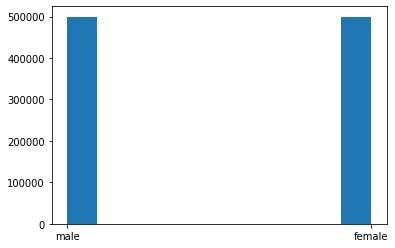

In [7]:
draw_categorical(df_infor, 'gender')

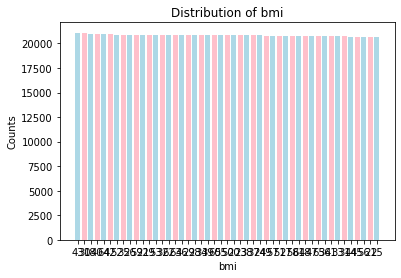

In [8]:
draw_numerical(df_full, 'age') 


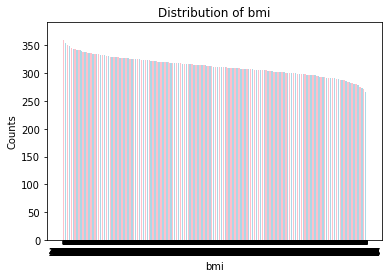

In [9]:
draw_numerical(df_full, 'bmi') 

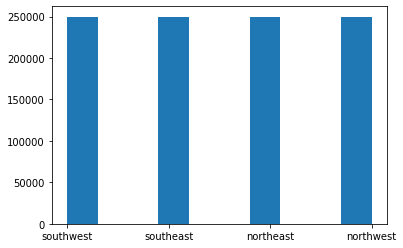

In [9]:
draw_categorical(df_infor, 'region')

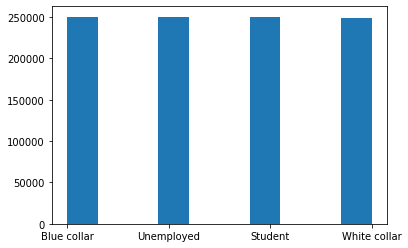

In [10]:
draw_categorical(df_infor, 'occupation')

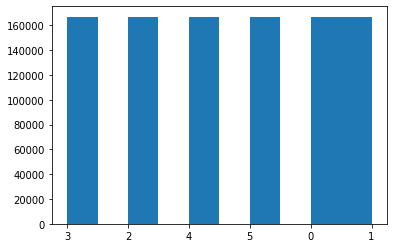

In [11]:
draw_categorical(df_infor, 'children')

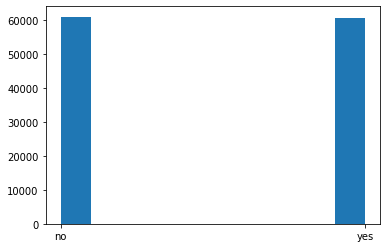

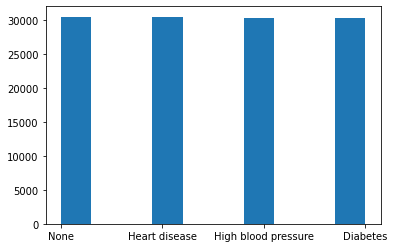

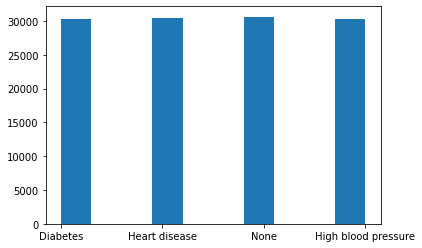

In [12]:
draw_categorical(df_srw, 'smoker')
draw_categorical(df_srw, 'medical_history')
draw_categorical(df_srw, 'family_medical_history')

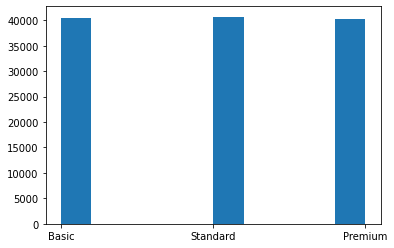

In [15]:
draw_categorical(df_srw, 'coverage_level')

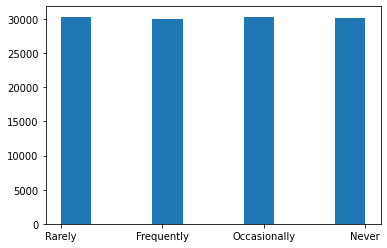

In [17]:
draw_categorical(df_srw, 'exercise_frequency')

## Vertify the data quanlity

In [4]:
df_srw.dtypes

[('ID', 'string'),
 ('bmi', 'string'),
 ('smoker', 'string'),
 ('medical_history', 'string'),
 ('family_medical_history', 'string'),
 ('exercise_frequency', 'string'),
 ('coverage_level', 'string'),
 ('charges', 'string')]

In [5]:
df_infor.dtypes

[('ID', 'string'),
 ('age', 'string'),
 ('gender', 'string'),
 ('region', 'string'),
 ('occupation', 'string'),
 ('children', 'string'),
 ('charges', 'string')]

# 3. Data Prepration

In [5]:
from pyspark.sql.functions import col, isnan, when, count
df_srw.select([count(when(col(c).contains('None')|col(c).contains('NULL')|(col(c)=='')|(col(c)=='NA')|\
              col(c).isNull()|isnan(c), c)).alias(c)for c in df_srw.columns]).show()

+---+----+------+---------------+----------------------+------------------+--------------+-------+
| ID| bmi|smoker|medical_history|family_medical_history|exercise_frequency|coverage_level|charges|
+---+----+------+---------------+----------------------+------------------+--------------+-------+
|  0|2118|    35|          30516|                 30668|               947|           116|   1325|
+---+----+------+---------------+----------------------+------------------+--------------+-------+



In [6]:
df_infor.select([count(when(col(c).contains('None')|col(c).contains('NULL')|(col(c)=='')|(col(c)=='NA')|\
              col(c).isNull()|isnan(c), c)).alias(c)for c in df_infor.columns]).show()

+---+----+------+------+----------+--------+-------+
| ID| age|gender|region|occupation|children|charges|
+---+----+------+------+----------+--------+-------+
|  0|1649|  1062|  2391|       547|     262|  11219|
+---+----+------+------+----------+--------+-------+



In [7]:
df_full.select([count(when(col(c).contains('None')|col(c).contains('NULL')|(col(c)=='')|(col(c)=='NA')|\
              col(c).isNull()|isnan(c), c)).alias(c)for c in df_full.columns]).show()

+---+------+---+--------+------+------+---------------+----------------------+------------------+----------+--------------+-------+
|age|gender|bmi|children|smoker|region|medical_history|family_medical_history|exercise_frequency|occupation|coverage_level|charges|
+---+------+---+--------+------+------+---------------+----------------------+------------------+----------+--------------+-------+
|  0|     0|  0|       0|     0|     0|         250762|                250404|                 0|         0|             0|      0|
+---+------+---+--------+------+------+---------------+----------------------+------------------+----------+--------------+-------+



In [8]:
df_srw = df_srw.drop('exercise_frequency')
df_srw.show()

+---+---+------+-------------------+----------------------+--------------+-----------+
| ID|bmi|smoker|    medical_history|family_medical_history|coverage_level|    charges|
+---+---+------+-------------------+----------------------+--------------+-----------+
|  1|100|    no|               None|              Diabetes|         Basic| 10390.1624|
|  2|100|    no|      Heart disease|         Heart disease|         Basic|15055.95902|
|  3|100|   yes|High blood pressure|                  None|         Basic| 16231.5286|
|  4|100|   yes|               None|              Diabetes|      Standard| 17169.3328|
|  5|100|   yes|           Diabetes|              Diabetes|      Standard|17207.14553|
|  6|100|    no|           Diabetes|         Heart disease|      Standard|16206.20829|
|  7|100|    no|               None|              Diabetes|       Premium|15603.15963|
|  8|100|    no|High blood pressure|                  None|       Premium|17695.81009|
|  9|100|   yes|      Heart disease|       

In [9]:
#Convert the string type varibale into integer or float
df_infor = df_infor.withColumn("age", col("age").cast("int"))
df_infor = df_infor.withColumn("children", col("children").cast("int"))
df_infor = df_infor.withColumn("charges", col("charges").cast("int"))
df_srw = df_srw.withColumn("bmi", col("bmi").cast("int"))
df_srw = df_srw.withColumn("charges", col("charges").cast("int"))

In [10]:
df_infor.dtypes


[('ID', 'string'),
 ('age', 'int'),
 ('gender', 'string'),
 ('region', 'string'),
 ('occupation', 'string'),
 ('children', 'int'),
 ('charges', 'int')]

In [11]:
df_srw.dtypes

[('ID', 'string'),
 ('bmi', 'int'),
 ('smoker', 'string'),
 ('medical_history', 'string'),
 ('family_medical_history', 'string'),
 ('coverage_level', 'string'),
 ('charges', 'int')]

In [12]:
df_srw = df_srw.na.drop('any')
df_infor = df_infor.na.drop('any')

In [13]:
df_srw.select([count(when(col(c).contains('None')|col(c).contains('NULL')|(col(c)=='')|(col(c)=='NA')|\
              col(c).isNull()|isnan(c), c)).alias(c)for c in df_srw.columns]).show()

+---+---+------+---------------+----------------------+--------------+-------+
| ID|bmi|smoker|medical_history|family_medical_history|coverage_level|charges|
+---+---+------+---------------+----------------------+--------------+-------+
|  0|  0|     0|          29783|                 30001|             0|      0|
+---+---+------+---------------+----------------------+--------------+-------+



In [14]:
df_infor.select([count(when(col(c).contains('None')|col(c).contains('NULL')|(col(c)=='')|(col(c)=='NA')|\
              col(c).isNull()|isnan(c), c)).alias(c)for c in df_infor.columns]).show()

+---+---+------+------+----------+--------+-------+
| ID|age|gender|region|occupation|children|charges|
+---+---+------+------+----------+--------+-------+
|  0|  0|     0|     0|         0|       0|      0|
+---+---+------+------+----------+--------+-------+



In [15]:
#integrate two data set
df_infor = df_infor.drop('charges')
insurance_df = df_infor.join(df_srw,['ID'], how='inner').drop('ID')

In [16]:
insurance_df.columns

['age',
 'gender',
 'region',
 'occupation',
 'children',
 'bmi',
 'smoker',
 'medical_history',
 'family_medical_history',
 'coverage_level',
 'charges']

In [17]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def create_new_feature(bmi, smoker, medical_history):
    if bmi < 25 and smoker == 'no' and medical_history == 'None':
        return '1'
    else:
        return '0'

# Register the UDF with PySpark
create_new_feature_udf = udf(create_new_feature, StringType())

# Apply the UDF to create the new column
merged_df = insurance_df.withColumn('Risk_Level', create_new_feature_udf(insurance_df['bmi'], insurance_df['smoker'], insurance_df['medical_history']))

In [18]:
from pyspark.sql import functions as F

value_counts = merged_df.groupBy('Risk_Level').count().orderBy('Risk_Level')
result = value_counts.collect()

# Print the result


In [19]:
#convert the data from characters into number
gender = {'female':1,'male':0}
smoker = {'yes':1, 'no':0}
region = {'southeast':0, 'northwest':1, 'southwest':2, 'northeast':3}
medical = {'Diabetes':1, 'None':0, 'High blood pressure':2, 'Heart disease':3}
occupation = {'Blue collar':0, 'Unemployed':1, 'Student':2, 'White collar':3}
coverage_level = {'Basic':0, 'Standard':1,'Premium':2}

data = merged_df.rdd.map(lambda x: (gender[x.gender], region[x.region], occupation[x.occupation], smoker[x.smoker],\
                                   medical[x.medical_history], medical[x.family_medical_history],\
                                    coverage_level[x.coverage_level], x.age, x.bmi, x.children, x.Risk_Level, x.charges)).toDF(['gender', 'region','occupation', 'smoker', 'medical_history',\
                                                                          'family_medical_history', 'coverage_level','age','bmi', 'children', 'Risk_Level','charges'])

In [20]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='gender', outputCol='gender_I')
data = indexer.fit(data).transform(data)

In [21]:
result_df = data.withColumn("Risk_Level", col("Risk_Level").cast("int"))
#result_df.dtypes

result_df.columns
r_df = result_df

# 4. Data transformation

In [22]:
#feature selection
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
cols_name = ['gender_I','region','occupation','smoker','medical_history','family_medical_history','coverage_level','Risk_Level',\
                   'age', 'bmi', 'children']

# Assemble the feature vector
assembler = VectorAssembler(inputCols=cols_name, outputCol="features")
assembled_df = assembler.transform(result_df)

In [23]:
lasso = LinearRegression(
    featuresCol="features",
    labelCol='charges', 
    elasticNetParam=1.0,       # This sets L1 regularization 
)

lasso_model = lasso.fit(assembled_df)

23/10/12 17:21:50 WARN Instrumentation: [f5389e29] regParam is zero, which might cause numerical instability and overfitting.
23/10/12 17:21:51 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/12 17:21:51 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/10/12 17:21:55 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [24]:
coefficients = lasso_model.coefficients
threshold = 0.0  # Set your own threshold
selected_feature_columns = [feature for i, feature in enumerate(cols_name) if coefficients[i] > threshold]
selected_df = assembled_df.select(selected_feature_columns)

print(selected_df)

DataFrame[gender_I: double, region: bigint, occupation: bigint, smoker: bigint, medical_history: bigint, family_medical_history: bigint, coverage_level: bigint, age: bigint, bmi: bigint, children: bigint]


In [25]:
#features balance
for c in cols_name:
    class_counts = result_df.groupBy(c).count().orderBy(c)
    class_counts.show()

+--------+-----+
|gender_I|count|
+--------+-----+
|     0.0|59369|
|     1.0|59361|
+--------+-----+



+------+-----+
|region|count|
+------+-----+
|     0|29674|
|     1|29345|
|     2|29851|
|     3|29860|
+------+-----+



+----------+-----+
|occupation|count|
+----------+-----+
|         0|29803|
|         1|29634|
|         2|29784|
|         3|29509|
+----------+-----+



+------+-----+
|smoker|count|
+------+-----+
|     0|59605|
|     1|59125|
+------+-----+



+---------------+-----+
|medical_history|count|
+---------------+-----+
|              0|29689|
|              1|29576|
|              2|29662|
|              3|29803|
+---------------+-----+



+----------------------+-----+
|family_medical_history|count|
+----------------------+-----+
|                     0|29916|
|                     1|29626|
|                     2|29538|
|                     3|29650|
+----------------------+-----+



+--------------+-----+
|coverage_level|count|
+--------------+-----+
|             0|39589|
|             1|39728|
|             2|39413|
+--------------+-----+



+----------+------+
|Risk_Level| count|
+----------+------+
|         0|115564|
|         1|  3166|
+----------+------+



+---+-----+
|age|count|
+---+-----+
| 18| 2493|
| 19| 2488|
| 20| 2526|
| 21| 2460|
| 22| 2525|
| 23| 2443|
| 24| 2496|
| 25| 2424|
| 26| 2570|
| 27| 2391|
| 28| 2477|
| 29| 2458|
| 30| 2499|
| 31| 2423|
| 32| 2448|
| 33| 2468|
| 34| 2513|
| 35| 2375|
| 36| 2434|
| 37| 2349|
+---+-----+
only showing top 20 rows



+---+-----+
|bmi|count|
+---+-----+
| 18| 3633|
| 19| 3716|
| 20| 3596|
| 21| 3576|
| 22| 3565|
| 23| 3511|
| 24| 3737|
| 25| 3648|
| 26| 3562|
| 27| 3644|
| 28| 3706|
| 29| 3619|
| 30| 3648|
| 31| 3604|
| 32| 3741|
| 33| 3568|
| 34| 3617|
| 35| 3767|
| 36| 3675|
| 37| 3719|
+---+-----+
only showing top 20 rows



+--------+-----+
|children|count|
+--------+-----+
|       0|19951|
|       1|19955|
|       2|19497|
|       3|19761|
|       4|19728|
|       5|19838|
+--------+-----+



In [26]:
#imbalanced ratio
a = round(115564/3166)

print("The imbalanced ratio for Risk level is", a)

The imbalanced ratio for Risk level is 37


In [27]:
#balance the model
#input_features = result_df.drop('charges')
input_features = result_df
majority_class = input_features.filter(col("Risk_Level") == 0)
minority_class = input_features.filter(col("Risk_Level") == 1)

# Resample the majority class to match the minority class
majority_count = majority_class.count()
minority_count = minority_class.count()

# Calculate the ratio for resampling
resampling_ratio = minority_count / majority_count

majority_downsampled = majority_class.sample(withReplacement=False, fraction=resampling_ratio, seed=42)

# Combine the resampled majority class with the minority class
balanced_df = minority_class.union(majority_downsampled)

# Verify the balance
balanced_category_counts = balanced_df.groupBy("Risk_Level").count()

# Show the counts for each category
balanced_category_counts.show()

print("Total instances in balanced dataset:", balanced_df.count())

+----------+-----+
|Risk_Level|count|
+----------+-----+
|         1| 3166|
|         0| 3230|
+----------+-----+



Total instances in balanced dataset: 6396


In [28]:
balanced_df.show()

+------+------+----------+------+---------------+----------------------+--------------+---+---+--------+----------+-------+--------+
|gender|region|occupation|smoker|medical_history|family_medical_history|coverage_level|age|bmi|children|Risk_Level|charges|gender_I|
+------+------+----------+------+---------------+----------------------+--------------+---+---+--------+----------+-------+--------+
|     0|     2|         3|     0|              0|                     0|             2| 37| 23|       1|         1|  13782|     1.0|
|     1|     2|         1|     0|              0|                     0|             2| 21| 22|       0|         1|   8904|     0.0|
|     1|     3|         3|     0|              0|                     3|             2| 21| 22|       2|         1|  16560|     0.0|
|     1|     3|         3|     0|              0|                     3|             1| 58| 19|       0|         1|  15768|     0.0|
|     1|     1|         1|     0|              0|                    

In [75]:
conditions = [
    (balanced_df['charges'] >= 22856),
    (balanced_df['charges'] < 22856)
]

# Define the corresponding categories
categories = [1, 2]

# Add a new column "charges_category" based on the conditions
balanced_df = balanced_df.withColumn(
    "charges_category",
    when(conditions[0], categories[0])
    .when(conditions[1], categories[1])
    .otherwise(None)
)

# Show the resulting DataFrame
balanced_df.show()

+------+------+----------+------+---------------+----------------------+--------------+---+---+--------+----------+-------+--------+----------------+
|gender|region|occupation|smoker|medical_history|family_medical_history|coverage_level|age|bmi|children|Risk_Level|charges|gender_I|charges_category|
+------+------+----------+------+---------------+----------------------+--------------+---+---+--------+----------+-------+--------+----------------+
|     0|     2|         3|     0|              0|                     0|             2| 37| 23|       1|         1|  13782|     1.0|               2|
|     1|     2|         1|     0|              0|                     0|             2| 21| 22|       0|         1|   8904|     0.0|               2|
|     1|     3|         3|     0|              0|                     3|             2| 21| 22|       2|         1|  16560|     0.0|               2|
|     1|     3|         3|     0|              0|                     3|             1| 58| 19|     

In [76]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [77]:
balanced_df.columns

['gender',
 'region',
 'occupation',
 'smoker',
 'medical_history',
 'family_medical_history',
 'coverage_level',
 'age',
 'bmi',
 'children',
 'Risk_Level',
 'charges',
 'gender_I',
 'charges_category']

In [78]:
assembler = VectorAssembler(
  inputCols=['gender',
 'region',
 'occupation',
 'smoker',
 'medical_history',
 'family_medical_history',
 'coverage_level',
 'age',
 'bmi',
 'children',
 'Risk_Level',
 'gender_I'],
    outputCol="features")

In [79]:
output = assembler.transform(balanced_df)

In [80]:
# Split the training and testing set.
train_data,test_data = output.randomSplit([0.8,0.2])

In [81]:
rfc = RandomForestClassifier(labelCol='charges_category',featuresCol='features')

In [82]:
rfc_model = rfc.fit(train_data)

In [83]:
rfc_predictions = rfc_model.transform(test_data)

In [84]:
# Let's import the evaluator.
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error. 
acc_evaluator = MulticlassClassificationEvaluator(labelCol="charges_category", predictionCol="prediction", metricName="accuracy")

In [85]:
rfc_acc = acc_evaluator.evaluate(rfc_predictions)

In [86]:
print('A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc_acc*100))

A random forest ensemble has an accuracy of: 95.71%


In [87]:
rfc_model.toDebugString

'RandomForestClassificationModel: uid=RandomForestClassifier_7a588a5dd5b3, numTrees=20, numClasses=3, numFeatures=12\n  Tree 0 (weight 1.0):\n    If (feature 5 <= 2.5)\n     Predict: 2.0\n    Else (feature 5 > 2.5)\n     If (feature 10 <= 0.5)\n      If (feature 2 <= 0.5)\n       If (feature 3 <= 0.5)\n        Predict: 2.0\n       Else (feature 3 > 0.5)\n        If (feature 6 <= 0.5)\n         Predict: 2.0\n        Else (feature 6 > 0.5)\n         Predict: 1.0\n      Else (feature 2 > 0.5)\n       If (feature 4 <= 2.5)\n        Predict: 2.0\n       Else (feature 4 > 2.5)\n        If (feature 6 <= 1.5)\n         Predict: 2.0\n        Else (feature 6 > 1.5)\n         Predict: 1.0\n     Else (feature 10 > 0.5)\n      Predict: 2.0\n  Tree 1 (weight 1.0):\n    If (feature 4 <= 2.5)\n     If (feature 3 <= 0.5)\n      Predict: 2.0\n     Else (feature 3 > 0.5)\n      If (feature 5 <= 2.5)\n       Predict: 2.0\n      Else (feature 5 > 2.5)\n       If (feature 4 <= 0.5)\n        If (feature 6 <=

In [92]:
a = [90, 80, 50, 20]
for i in a:
    rfc = RandomForestClassifier(labelCol='charges_category',featuresCol='features', numTrees = i)
    rfc_model = rfc.fit(train_data)
    rfc_predictions = rfc_model.transform(test_data)
    acc_evaluator = MulticlassClassificationEvaluator(labelCol="charges_category", predictionCol="prediction", metricName="accuracy")
    rfc_acc = acc_evaluator.evaluate(rfc_predictions)
    print('A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc_acc*100))

A random forest ensemble has an accuracy of: 96.18%


A random forest ensemble has an accuracy of: 96.18%


A random forest ensemble has an accuracy of: 96.50%


A random forest ensemble has an accuracy of: 95.71%
